# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

## Обзор данных

Импортируем библиотеки и установим CatBoost

In [113]:
# установка catboost
!pip install catboost

In [114]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor 
from catboost import CatBoostRegressor

Создадим датафрейм, выведем информацию и первые 5 строк

In [115]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) # создаём датафрейм с компьютера
except:
    df = pd.read_csv('/datasets/autos.csv', index_col=[0], parse_dates=[0]) # создаём датафрейм с сервера

# выводим информацию    
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [116]:
# выводим первые 5 строк
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Убедимся в хронологичности дат

In [117]:
# убеждаемся, что время в колонке с индексами расположено хронологически
print(df.index.is_monotonic)

True


Данные находятся в хронологическом порядке, посмотрим на описание распределения и само распределение целевой величины:

In [118]:
# выводим описание выборки
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

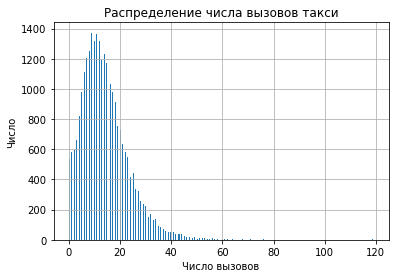

In [119]:
# строим гистограмму рапределения числа вызовов за 10 минут
df['num_orders'].hist(bins=300)
plt.title('Распределение числа вызовов такси')
plt.xlabel('Число вызовов') 
plt.ylabel('Число')
plt.show()

Распределение похоже на распределение Пуассона. Посмотрим на временной промежуток:

In [120]:
# выводим границы временного промежутка
print('Наш временной промежуток от', df.index.min(), 'до', df.index.max())

Наш временной промежуток от 2018-03-01 00:00:00 до 2018-08-31 23:50:00


Теперь напишем функцию, которая будет строить графики и построим зависимость числа вызовов за 10 минут от времени:

In [121]:
# функция, которая будет строенить диаграммы распределения, находить процент пропусков, выводить описание данных
def plot_maker(data, title):
    data.plot(grid=True, figsize=(12, 5))
    plt.xlabel('Время') 
    plt.ylabel('Число вызовов')
    plt.title(title) 
    plt.show()

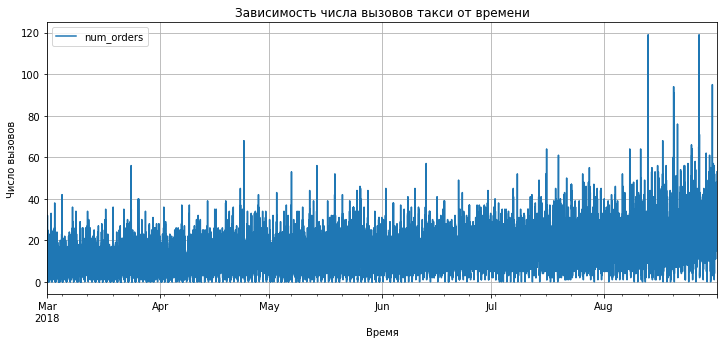

In [122]:
# строим зависимость числа вызовов такси от времени
plot_maker(df, 'Зависимость числа вызовов такси от времени')

Теперь выполним ресемплирование по 1 часу с суммированием:

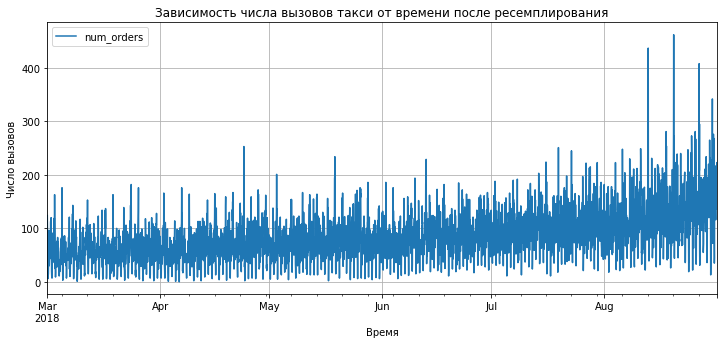

In [123]:
# выполняем ресемплирование по одному часу
df_resampled = df.resample('1H').sum()
# строим зависимость числа вызовов такси от времени после ресемплирования
plot_maker(df_resampled, 'Зависимость числа вызовов такси от времени после ресемплирования')

Данные всё ещё выглядят довольно шумно, выполним декомпозицию и посмотрим, если у данных тренд и сезонность.

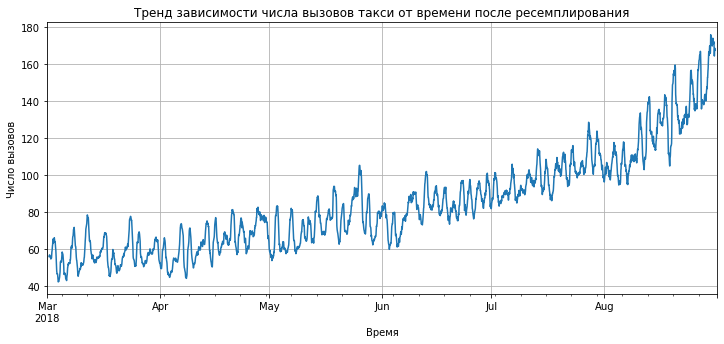

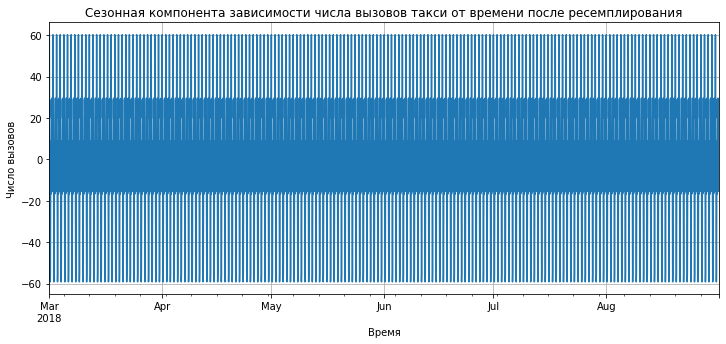

In [124]:
# проводим декомпозицию         
decomposed = seasonal_decompose(df_resampled)
# строим график тренда
plot_maker(decomposed.trend, 'Тренд зависимости числа вызовов такси от времени после ресемплирования')
plot_maker(decomposed.seasonal, 'Сезонная компонента зависимости числа вызовов такси от времени после ресемплирования')

Зависимость нестационарная. Наблюдается восходящий тренд. Рост весной и ещё более резкий рост в августе связаны, вероятно, активизацией туризма в более тёплые месяцы и летним сезоном отпусков. Сезонная компонента отражает суточные колебания, чтобы рассмотреть структуру, посмотрим на них в масштабе первых нескольких дней.

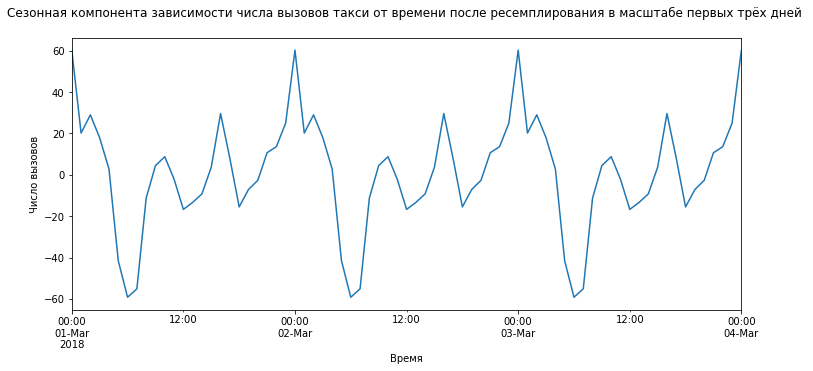

In [125]:
# строим график сезонной составляющей в масштабе первых трёх дней
decomposed.seasonal.plot(figsize=(12, 5))
plt.xlim('2018-03-01 00:00:00', '2018-03-04 00:00:00')
plt.xlabel('Время') 
plt.ylabel('Число вызовов')
plt.title('Сезонная компонента зависимости числа вызовов такси от времени после ресемплирования в масштабе первых трёх дней \n') 
plt.show()

В течение суток наблюдается три промежутка, когда такси вызывают наиболее часто - вероятно, это связано с расписанием прибытия рейсов.

Чтобы правильно подобрать количество лагов, построим график коэффициентов автокорреляции:

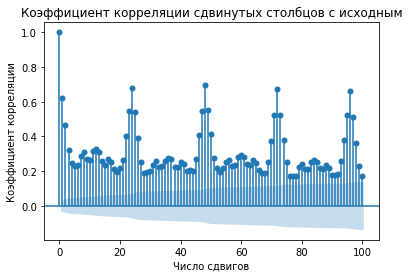

In [127]:
# строим график коэффициентов автокорреляции
sm.graphics.tsa.plot_acf(df_resampled.values, lags=100)
plt.title('Коэффициент корреляции сдвинутых столбцов с исходным')
plt.xlabel('Число сдвигов')
plt.ylabel('Коэффициент корреляции')
plt.show()

Здесь также можно отметить суточную периодичность, значит, стоит брать число лагов порядка 25-30.

## Подготовка признаков и подбор модели

### Подготовка признаков

В наш ресемплированный датасет добавим столбцы месяцем, числом и днём недели

In [98]:
# создаём признак, в котором хранится месяц как число
df_resampled['month'] = df_resampled.index.month
# создаём признак, в котором хранится число месяца
df_resampled['day'] = df_resampled.index.day
# создаём признак, в котором хранится день недели как число
df_resampled['dayofweek'] = df_resampled.index.dayofweek
# выводим первые пять строк 
df_resampled.head()

,num_orders,month,day,dayofweek
datetime,,,,
2018-03-01 00:00:00,124,3,1,3
2018-03-01 01:00:00,85,3,1,3
2018-03-01 02:00:00,71,3,1,3
2018-03-01 03:00:00,66,3,1,3
2018-03-01 04:00:00,43,3,1,3


### Подбор модели

Напишем функцию, которая будет добавлять к датасету некоторое число сдвинутых друг относительно друга столбцов с целевой величиной, а также столбец со скользящим средним. 

Так как качество модели может зависить от числа таких столбцов, попробуем три варианта исходных датасетов с 5, 25 и 30 сдвигами, но всего с одним вариантом столбца со скользящим средним.

In [100]:
# создаём функцию, которая создаст столбцы с запаздывающими значениями и скользящее среднее
def lags_maker(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

#создаём три копии нашего датафрейма
df_5 = df_resampled.copy()
df_25 = df_resampled.copy()
df_30 = df_resampled.copy()

# в цикле перебираем три варианта числа сдвигов
for data, i in [[df_5, 5], [df_25, 25], [df_30, 30]]:
    lags_maker(data, i, 5)

Напишем функцию model_adjuster, которая будет принимать модель и набор параметров. Внутри каждой функции будем отделять от каждого из трёх датасетов тренировочный набор и проводить на нём кросс-валидацию. Параметры моделей будем добавлять в списки, чтобы в конце представить результаты в виде таблицы.

In [101]:
# создаём списки для записи параметров моделей
name_list = []
rmse_list = []
lags_list = []

# создаём функцию model_adjuster, которая с помощью RandomizedSearchCV будет подбирать 
# гиперпараметры моделей, сохранять лучшие модели, выводить их параметры и MAE 
def model_adjuster(model, params, name):
    rscv = RandomizedSearchCV(model, param_distributions=params, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(), random_state=12345)
    
    # в цикле перебираем три варианта числа сдвигов
    for i, data in [[5, df_5], [25, df_25], [30, df_30]]:
        print('Число признаков со сдвигом: ', i)
        
        # делим выборку на тренировочную и тестовую
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()

        # отделяем целевой признак для тренировочной выборки
        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']

        # подбираем параметры
        search = rscv.fit(features_train, target_train)
        search_score = (-1*search.best_score_)**0.5
        params = search.best_params_
        estimator = search.best_estimator_
       
        print('RMSE: ', search_score)
        print('Параметры модели: ', params, '\n')
        name_list.append(name)
        rmse_list.append(search_score)
        lags_list.append(i)
  

Попробуем модели линейной регрессии, случайного леса и CatBoost.

#### Линейная регрессия

In [102]:
warnings.filterwarnings('ignore')
print('Линейная регрессия \n')
model = LinearRegression() # создаём модель
params = {}
model_adjuster(model, params, 'Линейная регрессия')

Линейная регрессия 

Число признаков со сдвигом:  5
RMSE:  31.800266704580423
Параметры модели:  {} 

Число признаков со сдвигом:  25
RMSE:  27.242035802470077
Параметры модели:  {} 

Число признаков со сдвигом:  30
RMSE:  26.75264444180133
Параметры модели:  {} 



#### Случайный лес

In [103]:
print('Случайный лес \n')
model = RandomForestRegressor(random_state=12345) # создаём модель
params={'max_depth':range(1,21), 
        'n_estimators':range(1,21)} # задаём параметры
model_adjuster(model, params, 'Случайный лес') # запускаем функцию model_adjuster

Случайный лес 

Число признаков со сдвигом:  5
RMSE:  32.193737149729145
Параметры модели:  {'n_estimators': 16, 'max_depth': 7} 

Число признаков со сдвигом:  25
RMSE:  26.530750580669768
Параметры модели:  {'n_estimators': 19, 'max_depth': 19} 

Число признаков со сдвигом:  30
RMSE:  26.55141312448025
Параметры модели:  {'n_estimators': 19, 'max_depth': 19} 



#### CatBoost

In [104]:
print('CatBoost \n')
model = CatBoostRegressor(random_state = 12345, verbose=False) # создаём модель
params = {'depth':range(1,6), 'iterations':[10, 100]} # задаём параметры
model_adjuster(model, params, 'CatBoost') # запускаем функцию model_adjuster

CatBoost 

Число признаков со сдвигом:  5
RMSE:  32.06256736701315
Параметры модели:  {'iterations': 100, 'depth': 2} 

Число признаков со сдвигом:  25
RMSE:  25.801421208350316
Параметры модели:  {'iterations': 100, 'depth': 4} 

Число признаков со сдвигом:  30
RMSE:  25.751787103012127
Параметры модели:  {'iterations': 100, 'depth': 5} 



#### Сравнение моделей

Посмотрим на наши результаты:

In [105]:
# создаём и выводим таблицу с результатами
final_table = pd.DataFrame(data={'Название модели':name_list, 'Число сдвигов':lags_list, 'RMSE':rmse_list})
display(final_table)

,Название модели,Число сдвигов,RMSE
0,Линейная регрессия,5,31.800267
1,Линейная регрессия,25,27.242036
2,Линейная регрессия,30,26.752644
3,Случайный лес,5,32.193737
4,Случайный лес,25,26.530751
5,Случайный лес,30,26.551413
6,CatBoost,5,32.062567
7,CatBoost,25,25.801421
8,CatBoost,30,25.751787


Самый низкий RMSE наблюдается у модели CatBoost на датасете с 30 сдвигами, эту модель выберем для тестирования.

### Тестирование модели

Так как мы каждый раз перезаписывали переменные features_train, target_train, снова поделим датасет с 30 сдвигами на тренировочную и тестовую выборки и разделим признаки, а затем протестируем модель.

In [106]:
# создаём модель
model = CatBoostRegressor(depth=5, iterations=100, random_state = 12345, verbose=False) 

# делим выборку на тренировочную и тестовую
train, test = train_test_split(df_30, shuffle=False, test_size=0.1)
train = train.dropna()

# отделяем целевой признак для тренировочной выборки
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

# отделяем целевой признак для тренировочной выборки
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('RMSE: ', mean_squared_error(predictions, target_test)**0.5)

RMSE:  41.99229143724966


Посмотрим, как соотносятся предсказание и реальность на графике:

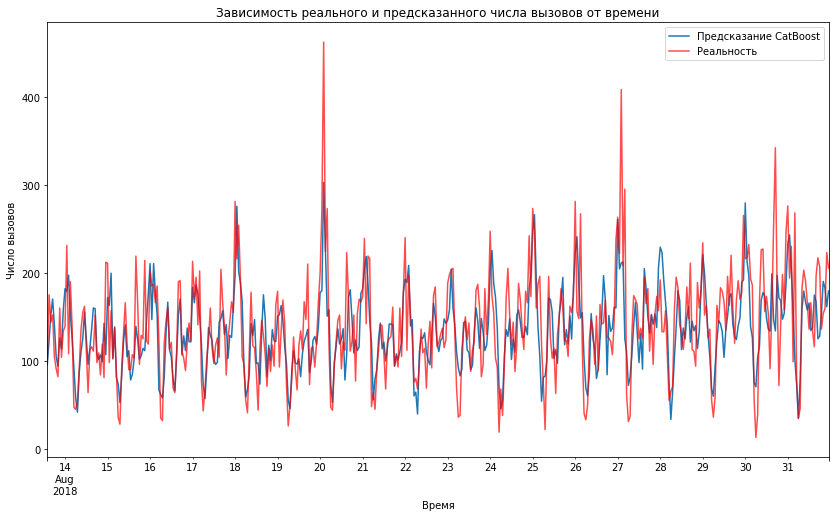

In [107]:
# создаём series из массива с предсказаниями
predictions_series = pd.Series(data=predictions, index=target_test.index)
# строим график для предсказанных и реальных значений
predictions_series.plot(figsize=(14, 8), label='Предсказание CatBoost', alpha=1)
target_test.plot(label='Реальность', color='red', alpha=0.7)
plt.legend()
plt.title('Зависимость реального и предсказанного числа вызовов от времени')
plt.xlabel('Время')
plt.ylabel('Число вызовов')
plt.show()

Совпадение не идеальное, но вполне удовлетворительное.

Теперь построим модель, которая будет предсказывать среднее значение и сравним её с моделью для тестирования.

In [108]:
# создаём dummy-regressor
dummy_regressor = DummyRegressor(strategy='mean')
# обучаем модель на всей тренировочной выборке
dummy_regressor.fit(features_train, target_train)
# делаем предсказание для тестовых данных
predictions = dummy_regressor.predict(features_test)
# находим и выводим mae
print('RMSE: ', mean_squared_error(predictions, target_test)**0.5)

RMSE:  84.63336276399527


## Выводы

- Данные охватывают число заказов такси за период с начала марта по конец августа и представляют собой нестационарную зависимость с восходящим трендом и суточной периодичностью
- Нам удалось построить модель, которая прогнозирует число заказов такси на следующий час и работает намного лучше, чем константная
- На качество всех трёх опробованных моделей заметно влияло количество сдвинутых столбцов целевого признака